# Predicting Default in Online Unsecured Personal Loans

## 1. Data Preprocessing

In [1]:
%matplotlib inline
import os 
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt 
import seaborn as sns

In [2]:
# import datasets
dta = pd.read_csv("..\\data\\loan_w_fico.csv", low_memory = False, skiprows = 1)

In [3]:
print(f'table dimensions of LC data: {dta.shape}')
dta.head()

table dimensions of LC data: (42538, 115)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [4]:
dta.describe(exclude = np.number)
print(f"number of unique IDs: {dta['member_id'].nunique()}")
print(f"IDS are unique: {dta['member_id'].nunique() == dta.shape[0]}") # assert member_id is primary key

number of unique IDs: 42535
IDS are unique: False


In [5]:
# drop current loans
dta['loan_status'].value_counts()
dta.drop(dta[dta['loan_status'] == 'Current'].index, inplace = True)

In [6]:
# Create Target Labels
print(dta['loan_status'].value_counts(dropna = False))
dta['target'] = np.where((dta['loan_status'] == 'Charged Off'), 1, 0)

Fully Paid                                             33586
Charged Off                                             5653
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
In Grace Period                                           16
Late (31-120 days)                                        12
Late (16-30 days)                                          5
NaN                                                        3
Default                                                    1
Name: loan_status, dtype: int64


## Missing Values

In [7]:
import missingno as msno

<AxesSubplot:>

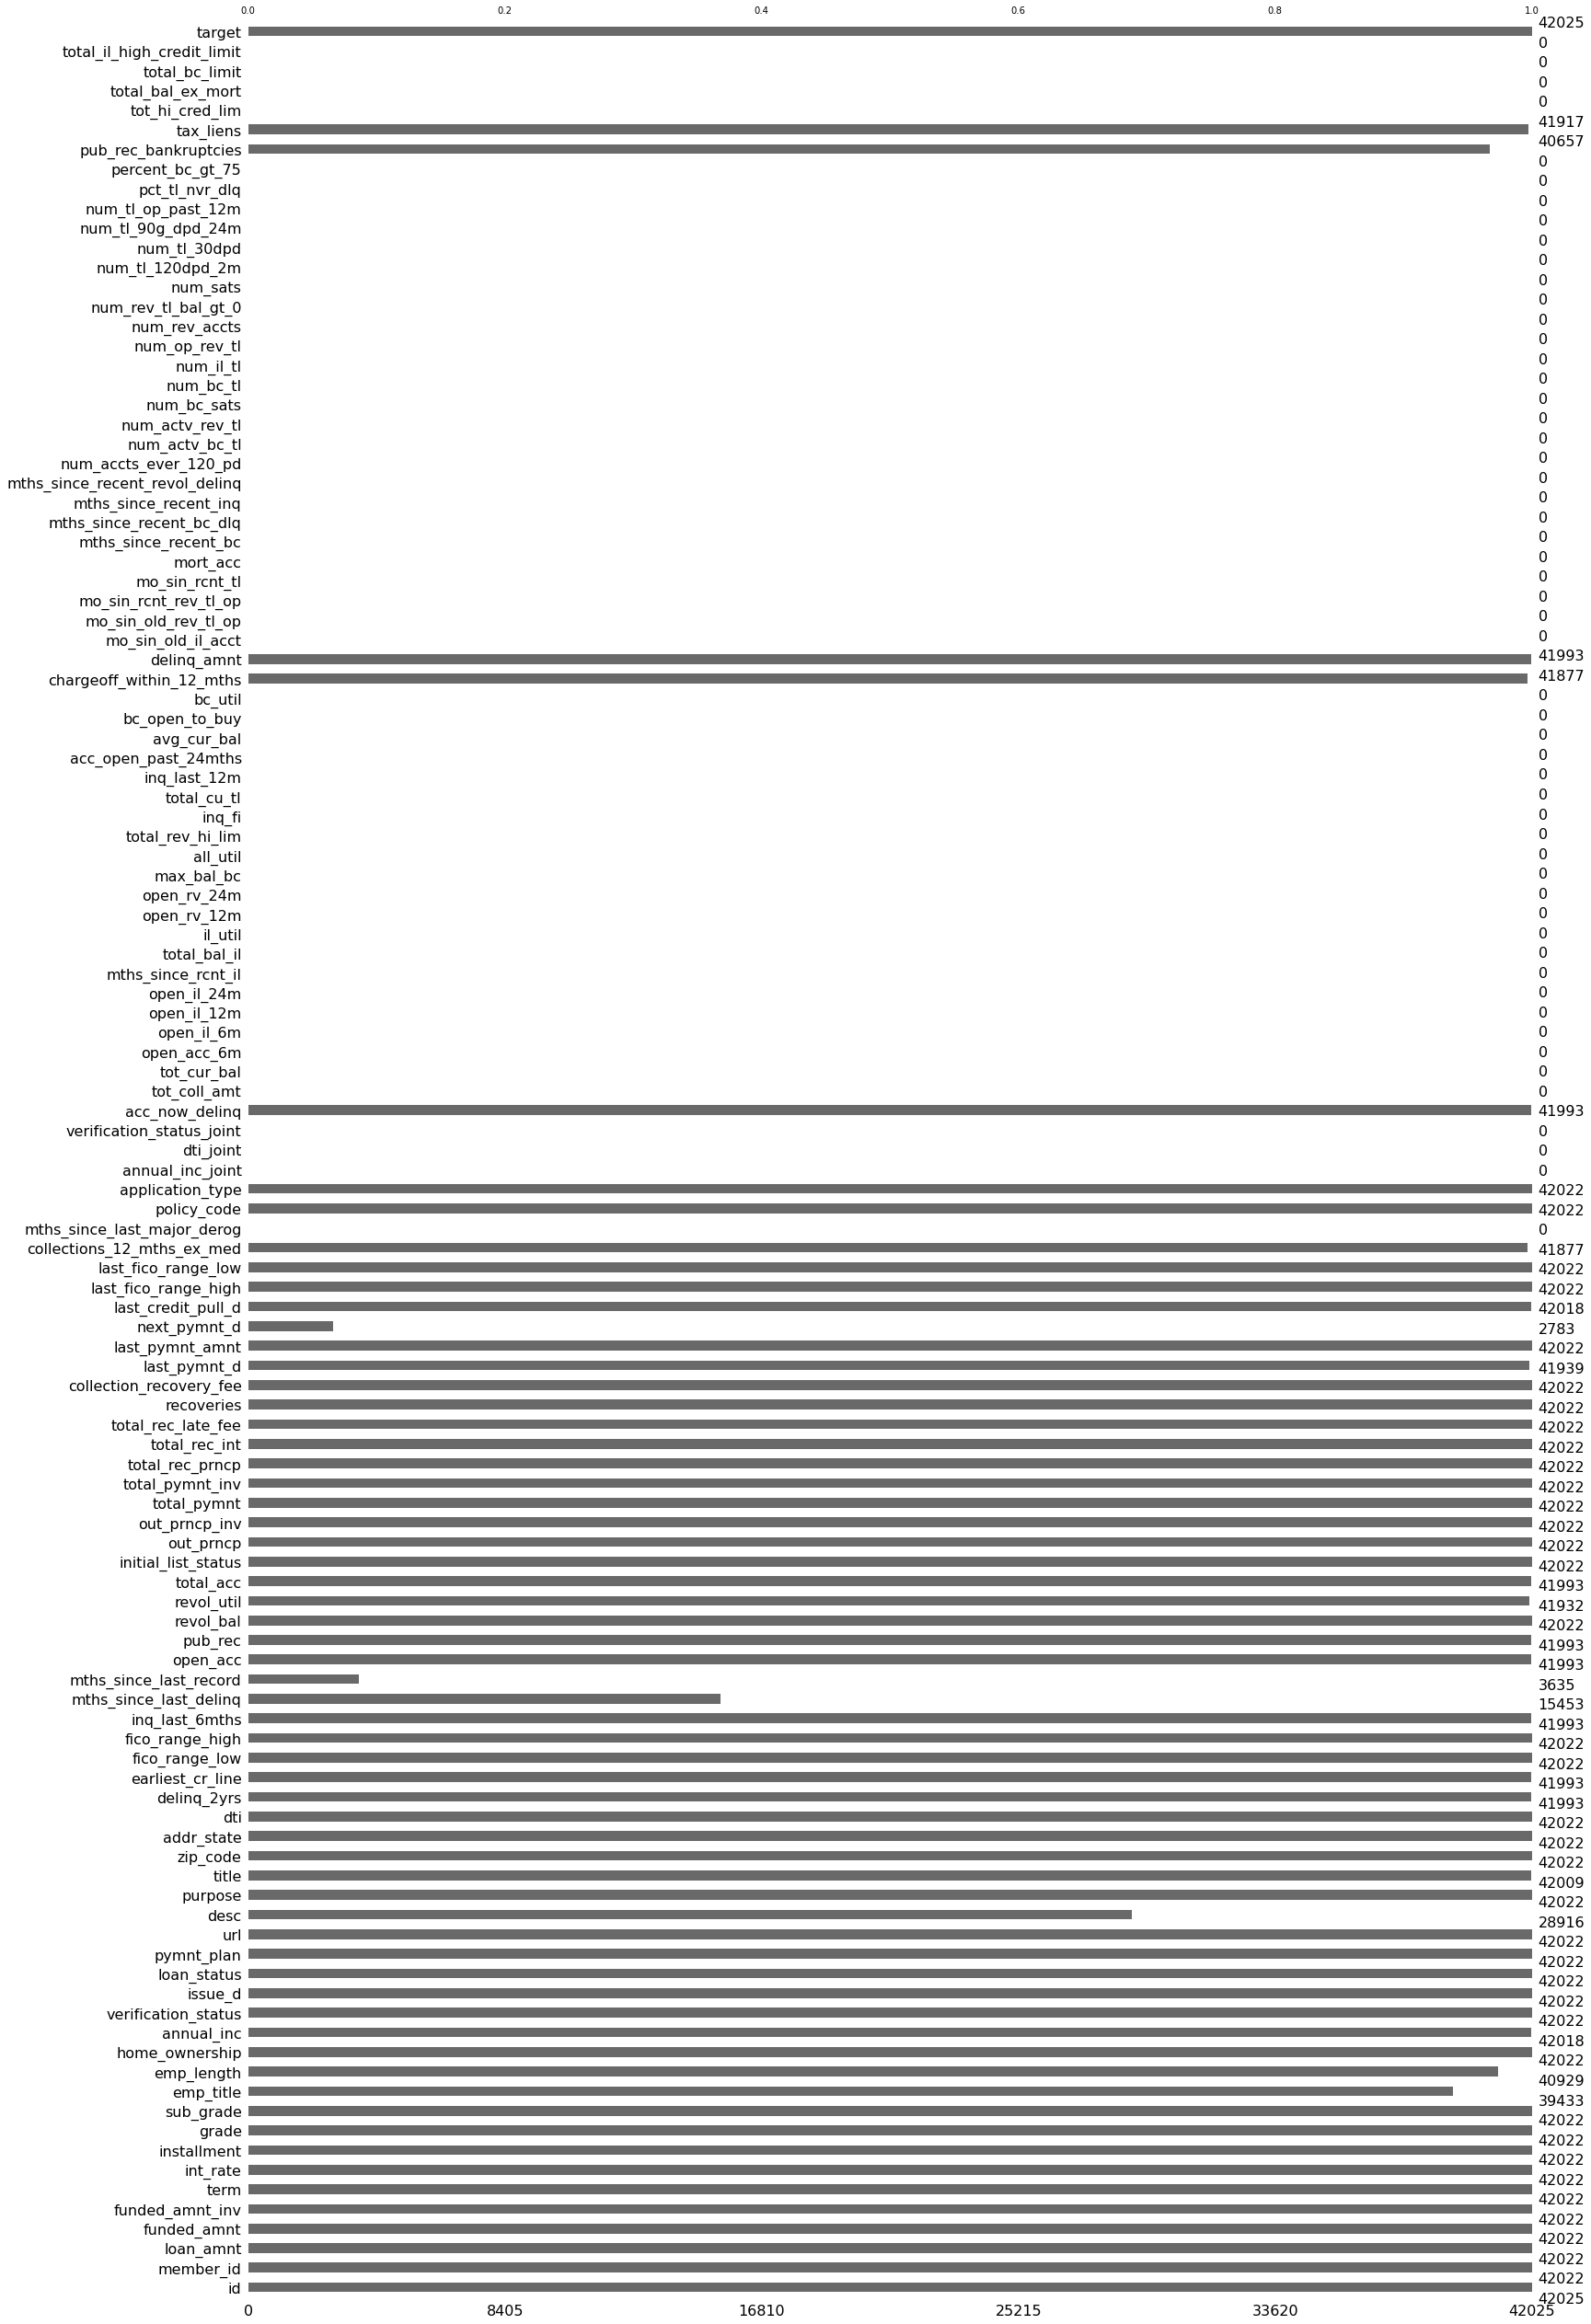

In [8]:
msno.bar(dta)

In [9]:
# drop columns with all missing values 
dta.dropna(axis = 1, how='all', inplace = True)

# List of tuples with variables and the proportion of missing values
missing = []

for i, j in enumerate(dta.isna().sum() / dta.shape[0]):
    if j == 0:
        continue
        
    missing.append((dta.columns[i], float('{:.4f}'.format(j))))
    
print("Tuples of variables and proportion of data missing: \n")
    
sorted(missing, key = lambda x: x[1], reverse = True)

Tuples of variables and proportion of data missing: 



[('next_pymnt_d', 0.9338),
 ('mths_since_last_record', 0.9135),
 ('mths_since_last_delinq', 0.6323),
 ('desc', 0.3119),
 ('emp_title', 0.0617),
 ('pub_rec_bankruptcies', 0.0326),
 ('emp_length', 0.0261),
 ('collections_12_mths_ex_med', 0.0035),
 ('chargeoff_within_12_mths', 0.0035),
 ('tax_liens', 0.0026),
 ('revol_util', 0.0022),
 ('last_pymnt_d', 0.002),
 ('delinq_2yrs', 0.0008),
 ('earliest_cr_line', 0.0008),
 ('inq_last_6mths', 0.0008),
 ('open_acc', 0.0008),
 ('pub_rec', 0.0008),
 ('total_acc', 0.0008),
 ('acc_now_delinq', 0.0008),
 ('delinq_amnt', 0.0008),
 ('title', 0.0004),
 ('annual_inc', 0.0002),
 ('last_credit_pull_d', 0.0002),
 ('member_id', 0.0001),
 ('loan_amnt', 0.0001),
 ('funded_amnt', 0.0001),
 ('funded_amnt_inv', 0.0001),
 ('term', 0.0001),
 ('int_rate', 0.0001),
 ('installment', 0.0001),
 ('grade', 0.0001),
 ('sub_grade', 0.0001),
 ('home_ownership', 0.0001),
 ('verification_status', 0.0001),
 ('issue_d', 0.0001),
 ('loan_status', 0.0001),
 ('pymnt_plan', 0.0001),
 

## Handling missing values

Noticeably, some are credit file items. 

In [10]:
print(dta['mths_since_last_record'].describe())

# Months since last record, thus missing means most people don't have a public record
dta['has_pub_rec'] = dta['mths_since_last_record'].notnull().astype(int)
dta['has_delin'] = dta['mths_since_last_delinq'].notnull().astype(int)
dta['has_desc'] = dta['desc'].notnull().astype(int)

count    3635.000000
mean       59.014305
std        47.173153
min         0.000000
25%         0.000000
50%        85.000000
75%       101.000000
max       129.000000
Name: mths_since_last_record, dtype: float64


In [11]:
credit_items = ['pub_rec_bankruptcies', 
                'collections_12_mths_ex_med', 
                'chargeoff_within_12_mths',
                'tax_liens'
                ]

# Fill derogatories with 0, since they're quite rare
for item in credit_items:
    print(dta[item].value_counts(dropna = False))
    dta[item].fillna(0, inplace = True)    

0.0    38816
1.0     1835
NaN     1368
2.0        6
Name: pub_rec_bankruptcies, dtype: int64
0.0    41877
NaN      148
Name: collections_12_mths_ex_med, dtype: int64
0.0    41877
NaN      148
Name: chargeoff_within_12_mths, dtype: int64
0.0    41916
NaN      108
1.0        1
Name: tax_liens, dtype: int64


In [12]:
# Revolving Utilization
dta['revol_util'] = dta['revol_util'].str.rstrip('%').astype('float') / 100
print(f"Minimum revolving utilization: {dta['revol_util'].min()}")
print(f"Maximum revolving utilization: {dta['revol_util'].max()}")
print(f"Count of missing revolving utilizations: {dta['revol_util'].isna().sum()}")
dta['revol_util'].fillna(0, inplace = True)

# Interest Rate - This is ex-post so do not include as a feature!
dta['int_rate'] = dta['int_rate'].str.rstrip('%').astype('float') / 100

Minimum revolving utilization: 0.0
Maximum revolving utilization: 1.19
Count of missing revolving utilizations: 93


In [13]:
dta['purpose'].value_counts(dropna=False)
dta['purpose'].fillna('other', inplace = True)

In [14]:
# drop missing fico scores
dta[~(dta['last_fico_range_high'].between(350,850))]['last_fico_range_high'].count()
dta = dta[(dta['last_fico_range_high'].between(350,850))]

In [15]:
# drop missing inquiries
dta.inq_last_6mths.isna().sum()                
dta.dropna(subset=['inq_last_6mths'], inplace = True)

### Outlier Detection
Look for outliers that may be implausible

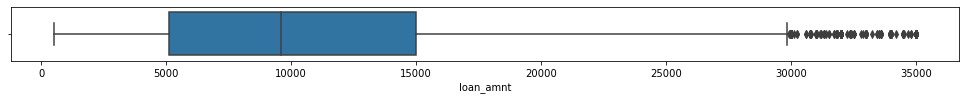

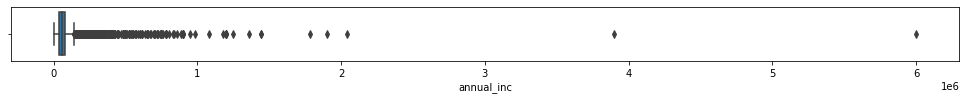

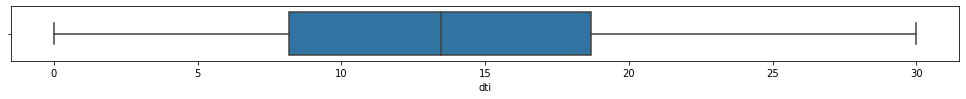

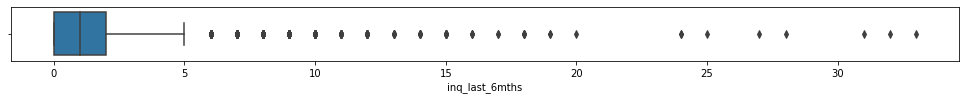

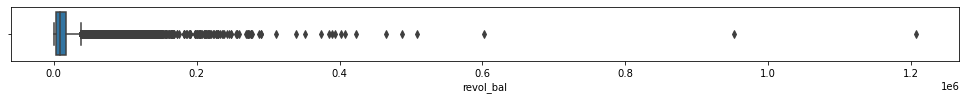

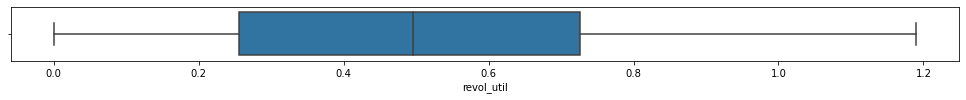

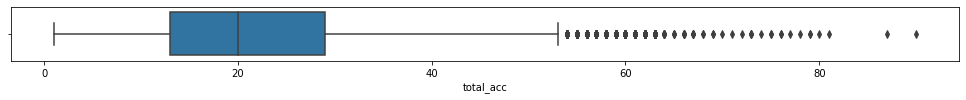

In [16]:
to_check = ['loan_amnt',
'annual_inc',
'dti',
'inq_last_6mths',
'revol_bal',
'revol_util',
'total_acc']

for column in to_check:
    plt.figure(figsize = (17,1))
    sns.boxplot(data = dta, x = column)

In [17]:
# Winsorize (1%) Annual Income, Revolving Balance and Total Accounts
# to mitigate effect of extreme outliers in this case
from scipy.stats.mstats import winsorize

def winsor(s):
    return winsorize(s, limits = [0.01, 0.01])
to_winsor = ['annual_inc', 'revol_bal', 'total_acc']

dta[to_winsor] = dta[to_winsor].apply(winsor)

### 2. Exploratory Data Analysis - Preliminary Visualizations

In [18]:
import sidetable
plt.rcParams
plt.rcParams['figure.figsize'] = 10, 5

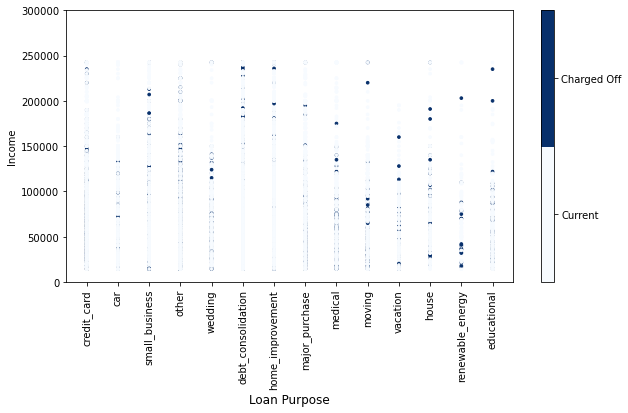

In [19]:
# The purpose of this graph is to see if some purposes (e.g. consumption) charge-off more frequently
# than others (e.g. investment)
plt.ticklabel_format(style = 'plain')
plt.scatter(x = dta['purpose'], y= dta['annual_inc'], \
            c = dta['target'], cmap = plt.cm.get_cmap('Blues', 2), s = 7)

names = ['Current','Charged Off']
formatter = plt.FuncFormatter(lambda val, loc: names[val])

plt.colorbar(ticks=[0, 1], format = formatter)
plt.clim(-0.5, 1.5)
plt.xticks(rotation = 'vertical')
plt.ylim(0, 3e5)
plt.ylabel('Income')
plt.xlabel('Loan Purpose', size= 12)
plt.show()

14.009207360226483
13.256351742184327


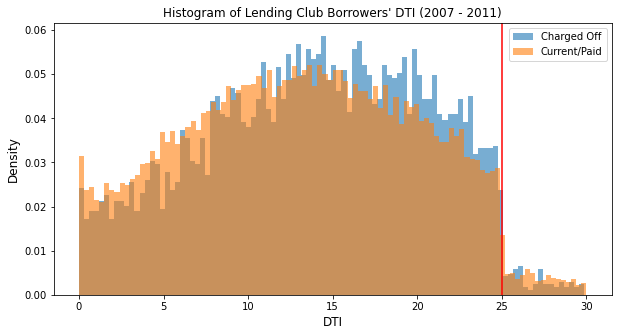

In [20]:
# Compare DTI distributions of people who are able to pay back v.s. not able 
dta['loan_status'].unique()

print(dta[dta['loan_status'] == 'Charged Off']['dti'].mean())
print(dta[dta['loan_status'] != 'Charged Off']['dti'].mean())

plt.hist(dta[dta['loan_status'] == 'Charged Off']['dti'], \
         bins = 100, alpha = 0.6, density = True, label = 'Charged Off')

plt.hist(dta[dta['loan_status'] != 'Charged Off']['dti'], \
         bins = 100, alpha = 0.6, density = True, label = 'Current/Paid')

plt.axvline(x=25, color = 'red')
plt.legend()
plt.xlabel('DTI', size = 12)
plt.ylabel('Density', size = 12)
plt.title("Histogram of Lending Club Borrowers' DTI (2007 - 2011)")
plt.show()

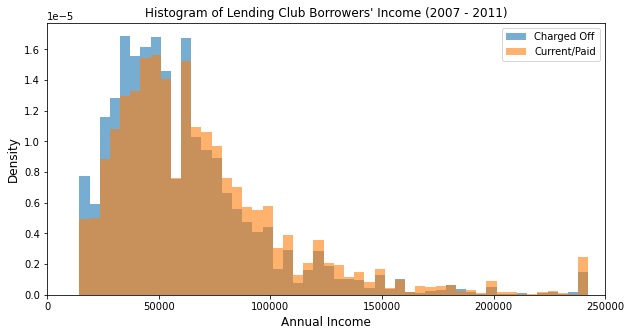

In [21]:
plt.hist(dta[(dta['loan_status'] == 'Charged Off') & (dta['annual_inc'] < 250000)]['annual_inc'], \
         bins = 50, alpha = 0.6, density = True, label = 'Charged Off')

plt.hist(dta[(dta['loan_status'] != 'Charged Off') & (dta['annual_inc'] < 250000)]['annual_inc'], \
         bins = 50, alpha = 0.6, density = True, label = 'Current/Paid')
plt.legend()
plt.xlabel('Annual Income', size = 12)
plt.ylabel('Density', size = 12)
plt.title("Histogram of Lending Club Borrowers' Income (2007 - 2011)")
plt.xlim(0,250000)

plt.show()

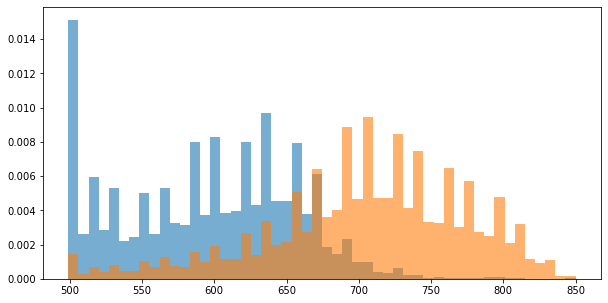

In [22]:
# fico - very predictive!

plt.hist(dta[(dta['loan_status'] == 'Charged Off')]['last_fico_range_high'], bins=50, alpha=0.6, density = True, label = 'Charged Off')
plt.hist(dta[(dta['loan_status'] != 'Charged Off')]['last_fico_range_high'], bins=50, alpha=0.6, density = True, label = 'Current/Paid')
plt.show()

#### Loan Descriptions

- clean loan descriptions and create bigrams to see patterns in text

In [23]:
import nltk
import re
import string
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [24]:
stemmer = PorterStemmer()

In [25]:
# temporarily upsample, only to capture patterns in text
from sklearn.utils import resample
from sklearn.utils import shuffle

labels = dta['target']
currents = dta[dta['target'] == 0]
defaults = dta[dta['target'] == 1]

dta_ups = resample(defaults, 
                   replace = True, 
                   n_samples = currents.shape[0], 
                   random_state = 99999)

dta_ups = pd.concat([currents, dta_ups])
dta_ups = shuffle(dta_ups)
dta_ups.reset_index(inplace=True)

In [26]:
raw_text = dta_ups['desc']
clean_text = raw_text.fillna('')

In [27]:
## Clean string

clean_text = [x.lower() for x in list(clean_text)] # lowercase
clean_text = [x.replace("<br>", "") for x in clean_text] # Exclude some mkd characters 
clean_text = [x.replace("<br/>", "") for x in clean_text]

def remove_log(my_str):
    return re.sub(r"borrower added on [0-9][0-9]\/[0-9][0-9]\/[0-9][0-9] > ", "", my_str)
clean_text = [remove_log(x) for x in clean_text] # Exclude "borrower added on {date} >"

clean_text = [" ".join(x.split()) for x in list(clean_text)] #trim internal and external spaces

puncs = string.punctuation
numbers = '0123456789'
def strip_puncs(x):
    return ''.join(char for char in x if char not in (puncs or numbers))
clean_text = [strip_puncs(x) for x in clean_text] # Get rid of punctuation

In [28]:
# Lemmatize and remove stop words
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

new_list = []

for text in clean_text:    
    words = word_tokenize(text)
    
    new_text = []
    
    for word in words:
        if word not in stop_words:
            lem_word = lemmatizer.lemmatize(word)
            new_text.append(lem_word)
        
    new_list.append(" ".join(new_text))

#### Bigrams

In [29]:
from nltk.util import ngrams

In [30]:
dta_ups['row_num'] = np.arange(len(dta_ups))

In [31]:
paid_dict = {}
chgoff_dict = {}
bag_bigrams = set()

# create bigrams 
for index, desc in enumerate(new_list):
    
    token = nltk.word_tokenize(desc)
    bigrams = set(ngrams(token, 2))    
    bag_bigrams |= bigrams
    
    default = (dta_ups['target'][index] == 1).astype(int)    
    paid = (dta_ups['target'][index] == 0).astype(int)    
    
    for bigram in bigrams:
        if bigram in paid_dict.keys():    
            paid_dict[bigram] += paid 
            chgoff_dict[bigram] += default
        else:                        
            paid_dict[bigram] = paid
            chgoff_dict[bigram] = default  

In [32]:
# now calculate the proportion
prop1_dict = {}
prop2_dict = {}

for bigram in bag_bigrams:
    if (paid_dict[bigram] >=1) and (chgoff_dict[bigram] >= 1):        
        prop1_dict[bigram] = (chgoff_dict[bigram])/(paid_dict[bigram])    
        prop2_dict[bigram] = (paid_dict[bigram])/(chgoff_dict[bigram])  

In [33]:
high_default = sorted(prop1_dict.items(), key=lambda x:x[1], reverse = True)[0:24]
high_default2 = sorted(prop1_dict.items(), key=lambda x:x[1], reverse = True)[25:49]

high_default_grams =  [lst[0] for lst in high_default]
high_default_counts =  [lst[1] for lst in high_default]

high_default_grams2 =  [lst[0] for lst in high_default2]
high_default_counts2 =  [lst[1] for lst in high_default2]

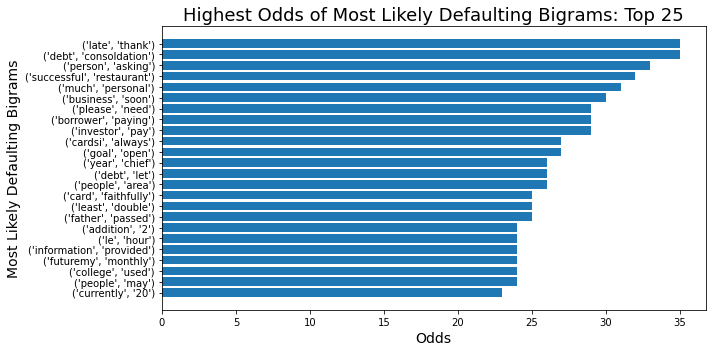

In [34]:
fig, ax = plt.subplots()

y_pos = np.arange(len(high_default_grams))
ax.barh(y_pos, high_default_counts, align = 'center')
ax.set_yticks(y_pos)
ax.set_yticklabels(high_default_grams)
ax.invert_yaxis()
ax.set_xlabel('Odds', size = 14)
ax.set_ylabel('Most Likely Defaulting Bigrams', size = 14)
ax.set_title('Highest Odds of Most Likely Defaulting Bigrams: Top 25', size = 18)
plt.tight_layout()
fig.savefig('chgoff_bigrams1.jpg')

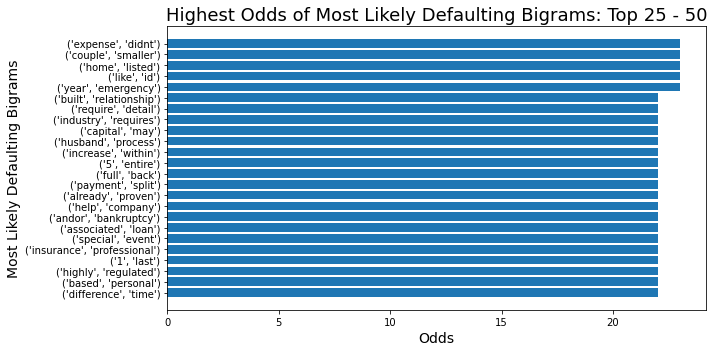

In [35]:
fig, ax = plt.subplots()

y_pos = np.arange(len(high_default_grams2))
ax.barh(y_pos, high_default_counts2, align = 'center')
ax.set_yticks(y_pos)
ax.set_yticklabels(high_default_grams2)
ax.invert_yaxis()
ax.set_xlabel('Odds', size = 14)
ax.set_ylabel('Most Likely Defaulting Bigrams', size = 14)
ax.set_title('Highest Odds of Most Likely Defaulting Bigrams: Top 25 - 50', size = 18)
plt.tight_layout()
fig.savefig('chgoff_bigrams2.jpg')

In [36]:
low_default = sorted(prop2_dict.items(), key=lambda x:x[1], reverse= True)[0:24]
low_default_grams =  [lst[0] for lst in low_default]
low_default_counts =  [lst[1] for lst in low_default]

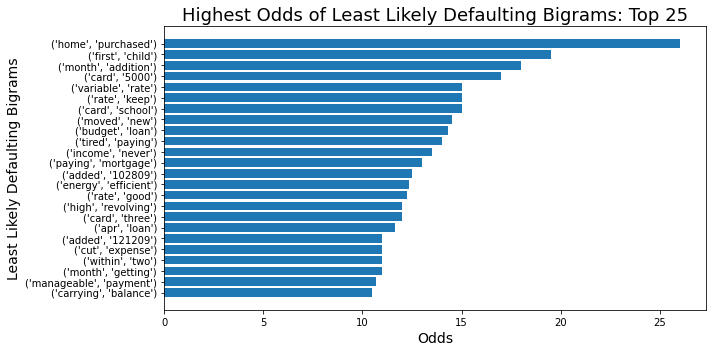

In [37]:
fig, ax = plt.subplots()

y_pos = np.arange(len(low_default_grams))
ax.barh(y_pos, low_default_counts, align = 'center')
ax.set_yticks(y_pos)
ax.set_yticklabels(low_default_grams)
ax.invert_yaxis()
ax.set_xlabel('Odds', size = 14)
ax.set_ylabel('Least Likely Defaulting Bigrams', size = 14)
ax.set_title('Highest Odds of Least Likely Defaulting Bigrams: Top 25', size = 18)
plt.tight_layout()
fig.savefig('paid_bigrams.jpg')

In [38]:
# save bigrams
top_bigrams = {}

for key in chgoff_dict.keys():
    top_bigrams[key] = chgoff_dict[key] + paid_dict[key]    

top_bigrams = sorted(top_bigrams.items(), key=lambda x:x[1], reverse= True)[0:200]
#top_bigrams = [x[0] for x in low_default + high_default]

dta_ups['clean_desc'] = new_list

bigrams_list = []
for text in new_list:
    bigrams = list(ngrams(nltk.word_tokenize(text), 2))
    bigrams_list.append(bigrams)
    
dta_ups['bigrams'] = bigrams_list    

In [39]:
# unpack tuple
top_bigrams = [x[0] for x in top_bigrams]

In [40]:
clean_descs = dta_ups[['id', 'clean_desc', 'bigrams']]
clean_descs.drop_duplicates(subset = 'id', inplace = True)

<ipython-input-40-7b2feb007f35>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_descs.drop_duplicates(subset = 'id', inplace = True)


In [41]:
dta = dta.merge(clean_descs, left_on = 'id', right_on ='id', how = 'inner')

In [42]:
import pickle

with open('top_grams.pkl', 'wb') as f:
    pickle.dump(top_bigrams, f)

with open('chgoff_grams.pkl', 'wb') as f:
    pickle.dump(high_default_grams, f)

with open('paid_grams.pkl', 'wb') as f:
    pickle.dump(low_default_grams, f)

In [43]:
# pickle data
dta.to_pickle("clean_dta.pkl")